# Objective

This example implements the EANet model for image classification, and demonstrates it on the CIFAR-100 dataset. 

# Installation of Packages

In [1]:
# !pip install -q tensorflow_datasets
# !pip install datasets
# !pip install keras_cv
# !pip install keras_hub

# Download Dataset from external source

# Importing packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import  metrics
from tensorflow.keras import losses
from tensorflow.keras import utils
from tensorflow.keras import callbacks
from tensorflow.keras import ops
from tensorflow.keras import regularizers
from tensorflow.keras import initializers
from tensorflow.keras import applications
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.datasets import cifar100
from tensorflow import keras

# from tensorflow.keras.datasets import mnist

# from keras.applications import EfficientNetB0
# import keras_cv
# import keras_hub

# Custom Functions

# Reading Data

In [3]:
(x_train, y_train), (x_test, y_test) =  cifar100.load_data()

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [4]:
val_split = 0.1
val_indices = int(len(x_train) * val_split)
x_train, y_train = x_train[val_indices:], y_train[val_indices:]

x_val, y_val = x_train[:val_indices], y_train[:val_indices]

# Data Inspection / Visualization

In [5]:
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape} - y_val shape: {y_test.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (45000, 32, 32, 3) - y_train shape: (45000, 1)
x_val shape: (5000, 32, 32, 3) - y_val shape: (10000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


In [6]:
numRows = x_train.shape[0]
numRows

45000

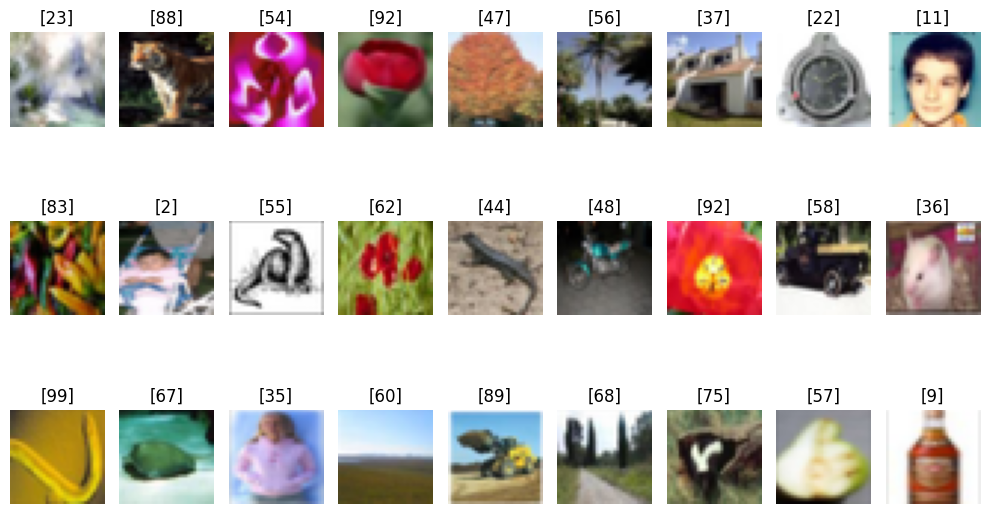

In [7]:
plt.figure(figsize=(10,8))
randomIndex = np.random.randint(0, numRows, 27)
for i in range(27):
    plt.subplot(4, 9, i+1)
    item = x_train[int(randomIndex[i])]
    plt.imshow(item)
    plt.title(y_train[int(randomIndex[i])])
    plt.axis(False)


plt.tight_layout()

# Data Preprocessing

In [8]:
num_classes = len(np.unique(y_train))
input_shape = (32, 32, 3)

num_classes

100

In [9]:
weight_decay = 0.0001
learning_rate = 0.001
label_smoothing = 0.1
validation_split = 0.2
batch_size = 128
num_epochs = 40
patch_size = 2  # Size of the patches to be extracted from the input images.
num_patches = (input_shape[0] // patch_size) ** 2  # Number of patch
embedding_dim = 64  # Number of hidden units.
mlp_dim = 64
dim_coefficient = 4
num_heads = 4
attention_dropout = 0.2
projection_dropout = 0.2
num_transformer_blocks = 8

print(f"Patch size: {patch_size} X {patch_size} = {patch_size ** 2} ")
print(f"Patches per image: {num_patches}")

Patch size: 2 X 2 = 4 
Patches per image: 256


In [10]:
#x_train = x_train.astype("float32") / 255
#x_test = x_test.astype("float32") / 255

# Make sure images have shape (28, 28, 1)
#x_train = np.expand_dims(x_train, -1)
#x_test = np.expand_dims(x_test, -1)

In [11]:
y_train = utils.to_categorical(y_train, num_classes)
y_val = utils.to_categorical(y_val, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape} - y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (45000, 32, 32, 3) - y_train shape: (45000, 100)
x_val shape: (5000, 32, 32, 3) - y_val shape: (5000, 100)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 100)


In [12]:
# augmentation_layers = [
#     keras.layers.RandomCrop(image_size, image_size),
#     keras.layers.RandomFlip("horizontal"),
# ]


# def augment_images(images):
#     for layer in augmentation_layers:
#         images = layer(images, training=True)
#     return images

data_augmentation = models.Sequential(
    [
        layers.Normalization(),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.1),
        layers.RandomContrast(factor=0.1),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [13]:
def make_datasets(images, labels, is_train=False):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if is_train:
        dataset = dataset.shuffle(batch_size * 10)
    dataset = dataset.batch(batch_size)
    if is_train:
        dataset = dataset.map(
            lambda x, y: (data_augmentation(x), y), num_parallel_calls=tf.data.AUTOTUNE
        )
    return dataset.prefetch(tf.data.AUTOTUNE)

In [14]:
train_dataset = make_datasets(x_train, y_train, is_train=True)
val_dataset = make_datasets(x_val, y_val)
test_dataset = make_datasets(x_test, y_test)

In [15]:
print(train_dataset)
print(val_dataset)
print(test_dataset)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 100), dtype=tf.float64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 100), dtype=tf.float64, name=None))>


# Data Postprocessing

In [16]:
class PatchExtract(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, x):
        B, C = ops.shape(x)[0], ops.shape(x)[-1]
        x = ops.image.extract_patches(x, self.patch_size)
        x = ops.reshape(x, (B, -1, self.patch_size * self.patch_size * C))
        return x

In [17]:
class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patch = num_patch
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        pos = ops.arange(start=0, stop=self.num_patch, step=1)
        return self.proj(patch) + self.pos_embed(pos)

In [18]:
def external_attention(
    x,
    dim,
    num_heads,
    dim_coefficient=4,
    attention_dropout=0,
    projection_dropout=0,
):
    _, num_patch, channel = x.shape
    assert dim % num_heads == 0
    num_heads = num_heads * dim_coefficient

    x = layers.Dense(dim * dim_coefficient)(x)
    # create tensor [batch_size, num_patches, num_heads, dim*dim_coefficient//num_heads]
    x = ops.reshape(x, (-1, num_patch, num_heads, dim * dim_coefficient // num_heads))
    x = ops.transpose(x, axes=[0, 2, 1, 3])
    # a linear layer M_k
    attn = layers.Dense(dim // dim_coefficient)(x)
    # normalize attention map
    attn = layers.Softmax(axis=2)(attn)
    # dobule-normalization
    attn = layers.Lambda(
        lambda attn: ops.divide(
            attn,
            ops.convert_to_tensor(1e-9) + ops.sum(attn, axis=-1, keepdims=True),
        )
    )(attn)
    attn = layers.Dropout(attention_dropout)(attn)
    # a linear layer M_v
    x = layers.Dense(dim * dim_coefficient // num_heads)(attn)
    x = ops.transpose(x, axes=[0, 2, 1, 3])
    x = ops.reshape(x, [-1, num_patch, dim * dim_coefficient])
    # a linear layer to project original dim
    x = layers.Dense(dim)(x)
    x = layers.Dropout(projection_dropout)(x)
    return x

In [19]:
def mlp(x, embedding_dim, mlp_dim, drop_rate=0.2):
    x = layers.Dense(mlp_dim, activation=ops.gelu)(x)
    x = layers.Dropout(drop_rate)(x)
    x = layers.Dense(embedding_dim)(x)
    x = layers.Dropout(drop_rate)(x)
    return x

In [20]:
def transformer_encoder(
    x,
    embedding_dim,
    mlp_dim,
    num_heads,
    dim_coefficient,
    attention_dropout,
    projection_dropout,
    attention_type="external_attention",
):
    residual_1 = x
    x = layers.LayerNormalization(epsilon=1e-5)(x)
    if attention_type == "external_attention":
        x = external_attention(
            x,
            embedding_dim,
            num_heads,
            dim_coefficient,
            attention_dropout,
            projection_dropout,
        )
    elif attention_type == "self_attention":
        x = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dim,
            dropout=attention_dropout,
        )(x, x)
    x = layers.add([x, residual_1])
    residual_2 = x
    x = layers.LayerNormalization(epsilon=1e-5)(x)
    x = mlp(x, embedding_dim, mlp_dim)
    x = layers.add([x, residual_2])
    return x

# Model

In [21]:
def create_model(attention_type="external_attention"):
    inputs = layers.Input(shape=input_shape)
    # Image augment
    # x = data_augmentation(inputs)
    # Extract patches.
    x = PatchExtract(patch_size)(inputs)
    # Create patch embedding.
    x = PatchEmbedding(num_patches, embedding_dim)(x)
    # Create Transformer block.
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(
            x,
            embedding_dim,
            mlp_dim,
            num_heads,
            dim_coefficient,
            attention_dropout,
            projection_dropout,
            attention_type,
        )

    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

In [22]:
custom_model = create_model(attention_type="external_attention")

In [23]:
#utils.plot_model(model, show_shapes=True)
#model.summary()

# Training

In [24]:
def run_experiment(model):
    
    

    # model.compile(
    #     optimizer=optimizer,
    #     loss=keras.losses.SparseCategoricalCrossentropy(
    #         from_logits=True 
    #     ),
    #     metrics=["accuracy"],
    # )

    model.compile(
        loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
        optimizer=keras.optimizers.AdamW( learning_rate=learning_rate, weight_decay=weight_decay ),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
            keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
      )
    
  

    checkpoint_filepath = "/tmp/checkpoint.keras"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=False,
     )

    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        batch_size=batch_size,
        epochs=num_epochs,
        # callbacks=[checkpoint_callback],
    )

    #model.load_weights(checkpoint_filepath)
    
    evaluation= model.evaluate(test_dataset)

    return history, model, evaluation

In [25]:
history, model, evaluation = run_experiment(custom_model)

Epoch 1/40


I0000 00:00:1733405787.630874      92 service.cc:145] XLA service 0x7990400021d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733405787.630939      92 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733405787.630944      92 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1733405855.834890      92 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_28', 136 bytes spill stores, 136 bytes spill loads

I0000 00:00:1733405855.910435      92 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


351/352 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.0412 - loss: 4.4501 - top-5-accuracy: 0.1502

I0000 00:00:1733405969.277009      92 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_28', 136 bytes spill stores, 136 bytes spill loads



352/352 ━━━━━━━━━━━━━━━━━━━━ 207s 339ms/step - accuracy: 0.0413 - loss: 4.4492 - top-5-accuracy: 0.1505 - val_accuracy: 0.0122 - val_loss: 134.5769 - val_top-5-accuracy: 0.0758
Epoch 2/40
352/352 ━━━━━━━━━━━━━━━━━━━━ 50s 140ms/step - accuracy: 0.1058 - loss: 4.0161 - top-5-accuracy: 0.3050 - val_accuracy: 0.0134 - val_loss: 140.0275 - val_top-5-accuracy: 0.1124
Epoch 3/40
352/352 ━━━━━━━━━━━━━━━━━━━━ 52s 149ms/step - accuracy: 0.1415 - loss: 3.8356 - top-5-accuracy: 0.3756 - val_accuracy: 0.0130 - val_loss: 140.7718 - val_top-5-accuracy: 0.0926
Epoch 4/40
352/352 ━━━━━━━━━━━━━━━━━━━━ 52s 146ms/step - accuracy: 0.1632 - loss: 3.7278 - top-5-accuracy: 0.4173 - val_accuracy: 0.0140 - val_loss: 136.1440 - val_top-5-accuracy: 0.0654
Epoch 5/40
352/352 ━━━━━━━━━━━━━━━━━━━━ 52s 147ms/step - accuracy: 0.1883 - loss: 3.6278 - top-5-accuracy: 0.4493 - val_accuracy: 0.0144 - val_loss: 135.0670 - val_top-5-accuracy: 0.0648
Epoch 6/40
352/352 ━━━━━━━━━━━━━━━━━━━━ 52s 148ms/step - accuracy: 0.2014 -

# Evaluation

In [26]:
loss, accuracy, top_5_accuracy = evaluation

print(f"Test loss: {round(loss, 2)}")
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

 # _, accuracy = evaluation
 #    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

Test loss: 300.95
Test accuracy: 1.11%
Test top 5 accuracy: 11.68%


In [27]:
def make_plot(metric):
  plt.plot(history.history[metric ])
  plt.plot(history.history['val_'+metric ])
  plt.title( 'Model '+metric )
  plt.ylabel( metric.capitalize() )
  plt.xlabel( 'Epoch' )
  plt.legend([ 'Train' , 'Validation' ], loc='upper left' )
  plt.show()

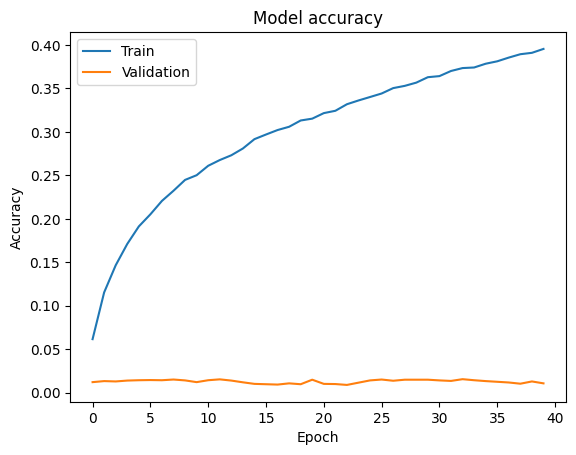

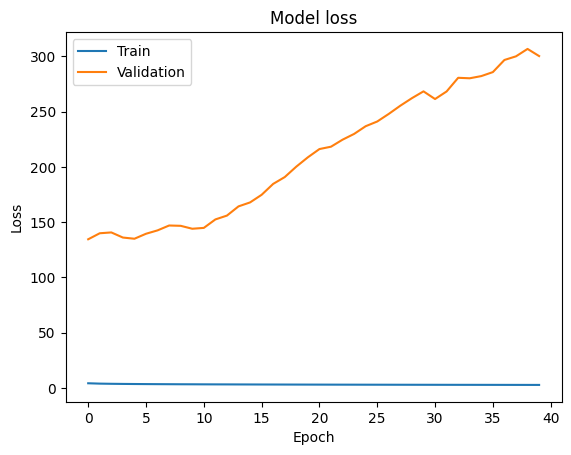

In [28]:
make_plot('accuracy')
make_plot('loss')

# Inference

# Deploy

In [29]:
#model.save("custom_image_classification_model")